# Transfer learning

В этом дз вам предстоит дообучить модель ResNet18 на датасете dogs-vs-cats.

Для начала понадобится зарегистрироваться на сайте Kaggle. Это одна из самых известных платформ для соревнований по анализу данных. А ещё там тоже можно пользоваться бесплатными видеокартами, если подтвердить аккаунт по номеру телефона.

Чтобы скачать оттуда интересующий нас датасет, можно воспользоваться инструкцией с сайта:
https://www.kaggle.com/discussions/general/74235

Заметим, что большую часть мы уже написали для вас, и по инструкции нужно лишь сгенерировать API токен и загрузить его сюда!

После этого необходимо ещё и принять принять правила соревнования (нажать кнопку Join competition и подтвердить согласие).
Ссылка на соревнование:
https://www.kaggle.com/c/dogs-vs-cats/data

In [ ]:
 from google.colab import files

files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip dogs-vs-cats.zip
!rm test1.zip
!mkdir -p ./dogcat
!unzip train.zip -d ./dogcat

Мы скачали данные. Давайте ниже напишем класс датасета. Формат данных у нас следующий: если в названии файла есть cat, то на картинке котик. А если dog, то пёсик.

In [1]:
import numpy as np
import pandas as pd
from glob import glob

import torch
from torch import nn

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time
import os
from tqdm import tqdm
from tempfile import TemporaryDirectory

from PIL import Image

Подготовим данные и разделим их на трейн и тест

In [2]:
images = glob("./train/*.jpg")

In [3]:
train, test = train_test_split(images, test_size = 0.3, random_state=42)

In [4]:
class CatDogDataset(Dataset):

    def __init__(self, paths, transform = None):

        self.paths = paths
        self.transform = transform


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        label = self.paths[index].split("/")[-1].split(".")[0]

        label = 0 if label == 'cat' else 1

        image = Image.open(self.paths[index])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [5]:
# Сделаем просто ресайз и нормалайз
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
import matplotlib.pyplot as plt

def imshow(inp):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
data = {"train": train, "val" : test}
image_datasets = {x: CatDogDataset(data[x], transform=data_transform)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

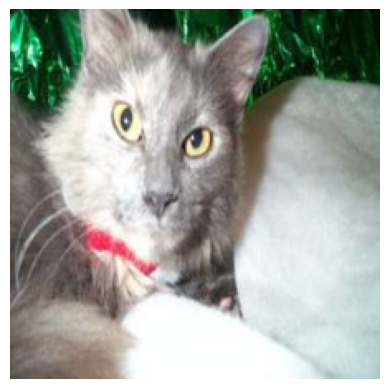

In [8]:
# Отрисуем одну картинку
imshow(image_datasets["train"].__getitem__(0)[0])

In [10]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [11]:
class_names = {0 : "cat", 1:"dog"}

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[int(preds[j])]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Далее вам нужно взять модель ResNet 18 и дообучить её на нашем датасете. Также понадобится посчитать количество параметров модели. Вы можете использовать любой код, а можете придерживаться примера ниже.

Код очень похож на первый видеоурок темы компьютерного зрения, не стесняйтесь туда подглядывать!

Ниже нужно обозначить модель, вызвать функцию обучения, и поработать с моделью.

In [12]:
from torchvision import datasets, models, transforms


model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 2)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, fused=True)

In [13]:
train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 547/547 [01:15<00:00,  7.21it/s]


train Loss: 0.0012 Acc: 0.9998


100%|██████████| 235/235 [00:26<00:00,  8.70it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 1/9
----------


100%|██████████| 547/547 [01:11<00:00,  7.62it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 235/235 [00:26<00:00,  8.92it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 2/9
----------


100%|██████████| 547/547 [01:11<00:00,  7.69it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 235/235 [00:26<00:00,  8.86it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 3/9
----------


100%|██████████| 547/547 [01:11<00:00,  7.68it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 235/235 [00:26<00:00,  8.89it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 4/9
----------


100%|██████████| 547/547 [01:10<00:00,  7.72it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 235/235 [00:26<00:00,  8.86it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 5/9
----------


100%|██████████| 547/547 [01:10<00:00,  7.71it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 235/235 [00:26<00:00,  8.92it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 6/9
----------


100%|██████████| 547/547 [01:10<00:00,  7.71it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 235/235 [00:26<00:00,  8.90it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 7/9
----------


100%|██████████| 547/547 [01:11<00:00,  7.70it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 235/235 [00:26<00:00,  8.93it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 8/9
----------


100%|██████████| 547/547 [01:10<00:00,  7.74it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 235/235 [00:26<00:00,  8.92it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 9/9
----------


100%|██████████| 547/547 [01:10<00:00,  7.70it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 235/235 [00:26<00:00,  8.77it/s]

val Loss: 0.0000 Acc: 1.0000

Training complete in 16m 21s
Best val Acc: 1.000000



C:\Temp\ipykernel_28144\357623423.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Задание 1. Посчитайте число параметров в модели

## Задание 2. Посчитайте Params size (MB)



In [21]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

11177538

In [17]:
# Возможно это вам тоже нужно
#!pip install torchinfo
from torchinfo import summary

summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 2]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

## Задание 3. Обучите модель на 5 эпохах и запомните (или запишите) accuracy. Это понадобится для ответа на вопрос теста. Запомните и качество после первой эпохи.

Будьте готовы, что обучение займет минут 10 на ГПУ в коллабе. Это ещё быстро...

In [ ]:
# YOUR CODE HERE -- TRAIN THE MODEL

## Задание 4. Сделайте то же самое, только без предобученной архитектуры. Это задается параметром weights со значением None. Стало ли качество лучше? Запомните и его.

In [ ]:
model_zero =  # YOUR CODE HERE

# AND HERE
model_zero.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_zero.parameters(), lr=0.001)

In [ ]:
# TRAIN MODEL ZERO HERE

Посмотрим чему научилась наша модель, обученная с 0:

In [ ]:
visualize_model(model_zero)

plt.ioff()
plt.show()

А с претрейном:

In [ ]:
visualize_model(model)

plt.ioff()
plt.show()

Отлично, вы справились с задачей и изучили основы компьютерного зрения! Дальше нас ждет захватывающий мир современного CV.
